# Hidden

In [2]:
import os
import re
import csv
import pandas as pd
import numpy as np
import json
import plotly.express as px
import plotly.graph_objects as go

In [3]:
def plot_heat_equation_info(df, title: str = ''):
    fig = px.bar(
        df, 
        x = 'precision',
        y = 'time', 
        color = 'id', 
        barmode='group',
        facet_row="xSize",
        facet_col="ySize",
        width=1440, 
        height=1024
      )

    fig.update_xaxes(title = '', type='category')
    fig.update_yaxes(title = '', matches=None)
    fig.layout.title = dict(text = title, x = 0.43)

    return fig

def plot_percentage_graph(df, x: str, y: str, title: str):
    return px.bar(df, 
                  x = x, 
                  y = y, 
                  title = title,
                  width=1440, 
                  height=540)

def plot_convolution_info_graph(df, dimension: int):
    fig = px.line(
        df[df['x-dimension'] == dimension], 
        x = 'kernel_size_id',
        y = 'time', 
        color = 'id',
        width=1600, 
        height=600,
        markers=True
      )

    return fig

def plot_3d_scatter(df):
    fig = px.scatter_3d(df, x='x', y='y', z='z', height = 1024, width = 1024)
    
    fig.update_traces(marker_size = 4)
    
    fig.update_layout(scene= dict(
                xaxis=dict(range=[df['x'].min(), df['x'].max()], autorange=False),
                yaxis=dict(range=[df['y'].min(), df['y'].max()], autorange=False),
                zaxis=dict(range=[-2., 20.], autorange=False)
            ))
    
    return fig

In [4]:
def plot_heat_equation_benchmarks(path: str, device: str, precision: str, title: str = ''):
    files = [file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    files = [file for file in files if device in file and precision in file]
    files = [os.path.join(path, file) for file in files if not file.endswith('.metadata.json')]
    
    lines = []
    
    for file in files:
        with open(file, 'r') as handle:
            lines += handle.readlines()
            
    lines = list(map(lambda line: json.loads(line), lines))
        
    df = pd.DataFrame(lines)
    
    for key in ['xSize', 'ySize', 'time', 'stddev', 'time', 'stddev', 'stddev/time']:
        df[key] = pd.to_numeric(df[key])

    df['size_id'] = df['xSize'].astype(str) + "x" + df['ySize'].astype(str)
    df['problem_size'] = (df['xSize'] * df['ySize']).astype(str)
    df['performer'] = df['performer'].str.slice(-4).str.lower()
    
    plot_heat_equation_info(df, title).show()
    
    # Calculate overhead in percents
    tnl_grid = df[df['id'] == 'tnl_grid'].reset_index()
    parallel_for = df[df['id'] == 'parallel_for'].reset_index()
    
    tnl_grid['overhead'] = tnl_grid['time'] - parallel_for['time']
    tnl_grid['overhead_percentage'] = tnl_grid['overhead'] / tnl_grid['time']
    
    plot_percentage_graph(tnl_grid, 
                          x='size_id', 
                          y='overhead_percentage', 
                          title='An overhead of the tnl grid implementation to the parallel for. (Measured in percents)').show()
    
    return df

In [24]:
def plot_convolution_benchmarks(path: str, id: str, xDimension: int):
    files = [file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    files = [file for file in files if id in file]
    files = [os.path.join(path, file) for file in files if not file.endswith('.metadata.json')]
        
    lines = []
    
    for file in files:
        with open(file, 'r') as handle:
            lines += handle.readlines()
            
    lines = list(map(lambda line: json.loads(line), lines))
    
    df = pd.DataFrame(lines)
    
    keys = ['bandwidth', 'loops', 'speedup', 'stddev', 'stddev/time', 'time', 'x-dimension', 'x-kernelSize', 'y-dimension', 'y-kernelSize', 'z-dimension', 'z-kernelSize']
    
    for key in keys:
        if key in df.keys():
            df[key] = pd.to_numeric(df[key])
            
    if 'z-dimension' in df.keys():
        df['dimension_size_id'] = df['x-dimension'].astype(str) + "x" + df['y-dimension'].astype(str) + "x" + df['z-dimension'].astype(str)
        df['kernel_size_id'] = df['x-kernelSize'].astype(str) + "x" + df['y-kernelSize'].astype(str) + "x"  + df['z-kernelSize'].astype(str)
        df = df[np.logical_and(df['x-kernelSize'] == df['y-kernelSize'], df['y-kernelSize'] == df['z-kernelSize'])] 
    elif 'y-dimension' in df.keys():
        df['dimension_size_id'] = df['x-dimension'].astype(str) + "x" + df['y-dimension'].astype(str)
        df['kernel_size_id'] = df['x-kernelSize'].astype(str) + "x" + df['y-kernelSize'].astype(str)
        df = df[df['x-kernelSize'] == df['y-kernelSize']]
    else:
        df['dimension_size_id'] = df['x-dimension'].astype(str)
        df['kernel_size_id'] = df['x-kernelSize'].astype(str)
    
    plot_convolution_info_graph(df, xDimension).show()
    
    return df
    
    
def plot_heat_equation_domain(path: str, id: str):
    files = [file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    files = [file for file in files if '_' + id + '.' in file]
    files = [os.path.join(path, file) for file in files]

    dfs = [pd.read_csv(file, delimiter = ' ', header = None, names = ['x', 'y', 'z']) for file in files]
    values = [df.copy() for df in dfs]
    
    dfs = [df.iloc[::2, :] for df in dfs]
    dfs = [df.iloc[::2, :] for df in dfs]
    
    for df in dfs:
        plot_3d_scatter(df).show()
        
    return values
    
def plot_heat_equation_domain_animated(path: str):
    files = [file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    files = [file for file in files if 'data' in file]
    files = sorted(files, key = lambda name: int(name.split('_')[1].split('.')[0]))
    files = [os.path.join(path, file) for file in files]
    
    print(files)

    files = [pd.read_csv(file, delimiter = ' ', header = None, names = ['x', 'y', 'z']) for file in files]
    files = [file.iloc[::2, :] for file in files]
    files = [file.iloc[::2, :] for file in files]
    
    fig = go.Figure(
        data = [go.Scatter3d(x=files[0]['x'], y = files[1]['y'], z = files[2]['z'], mode='markers')],
        layout=go.Layout(
            scene = dict(
                xaxis=dict(range=[-2, 2], autorange=False),
                yaxis=dict(range=[-2, 2], autorange=False),
                zaxis=dict(range=[-2., 20.], autorange=False)
            ),
            # 
            hovermode="closest",
            updatemenus=[dict(type="buttons",
                          buttons=[dict(label="Play",
                                        method="animate",
                                        args=[None])])]),
        frames = [go.Frame(data = go.Scatter3d(x=file['x'], y = file['y'], z = file['z'], mode='markers')) for file in files]
        
    )
    
    fig.update_layout(width = 1024, height = 1024)
    fig.update_traces(marker_size = 4)
    
    fig.show()

# Heat Equation (NVCC)

The following two sections describe show the benchmark results for the heat equation benchmark.
There are 4 implementations:

1. `tnl_grid` is the implementation of the heat equation using grids.
2. `parallel_for` is the implementation of the heat equation using TNL primitives like ParallelFor and others.
3. `parallel_for_with_emulated_entity` is the implementation of the heat equation using TNL privitives like ParallelFor and others. The implementation creates a mock grid structure to measure, if the it slows down the implementation.
4. `n_dim_grid` is a dummy implementation of the dimension-independent grid where the index of the entity is flattened into a single value.

The goal is to have minimal overhead difference between the `tnl_grid` and `parallel_for`.

Benchmarks calculate heat equation 10 times. Each calculation requires performing 10000 of iterations on the GPU and 1000 of iterations on the host.

## Float Precision

For small kernel sizes, the higher overhead percentage is acceptable, because they don't fully occupy the GPU and they execute signficantly faster, than the large kernels. 

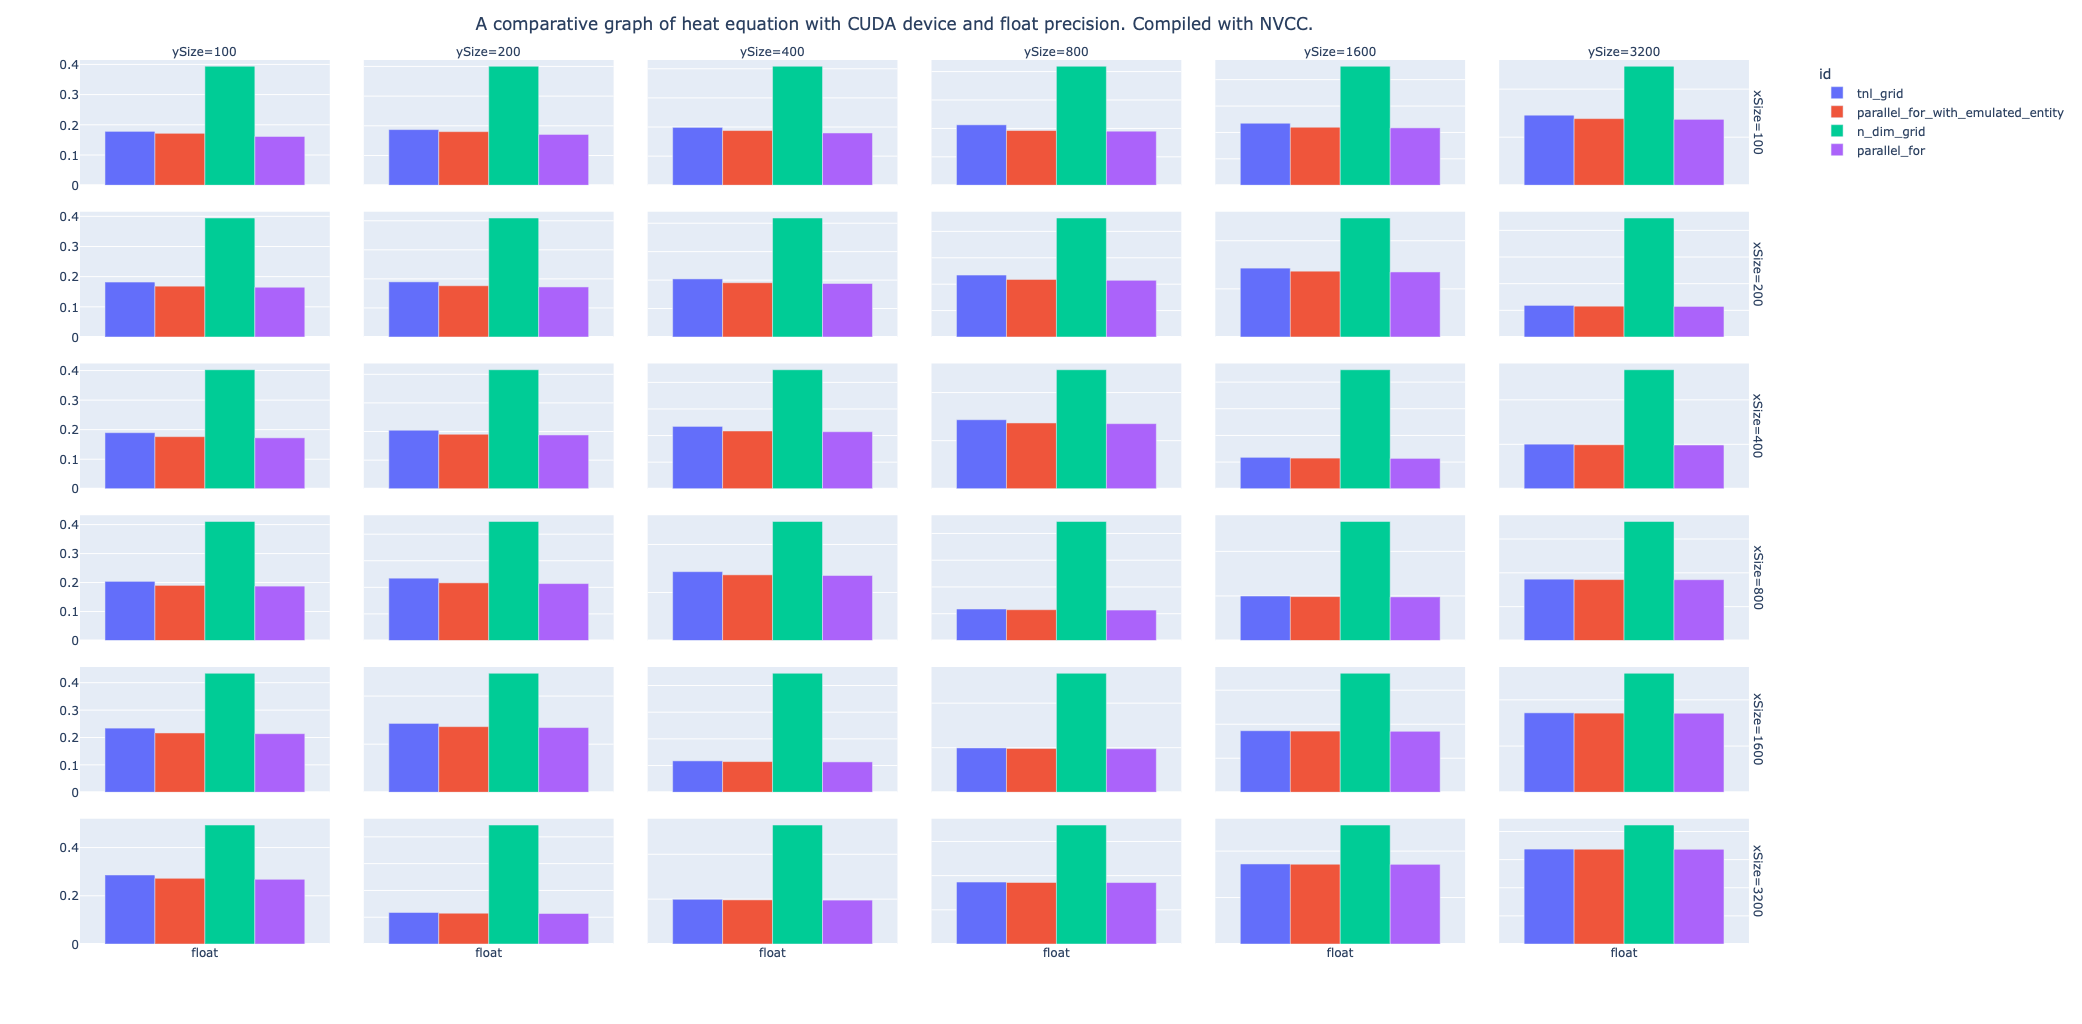

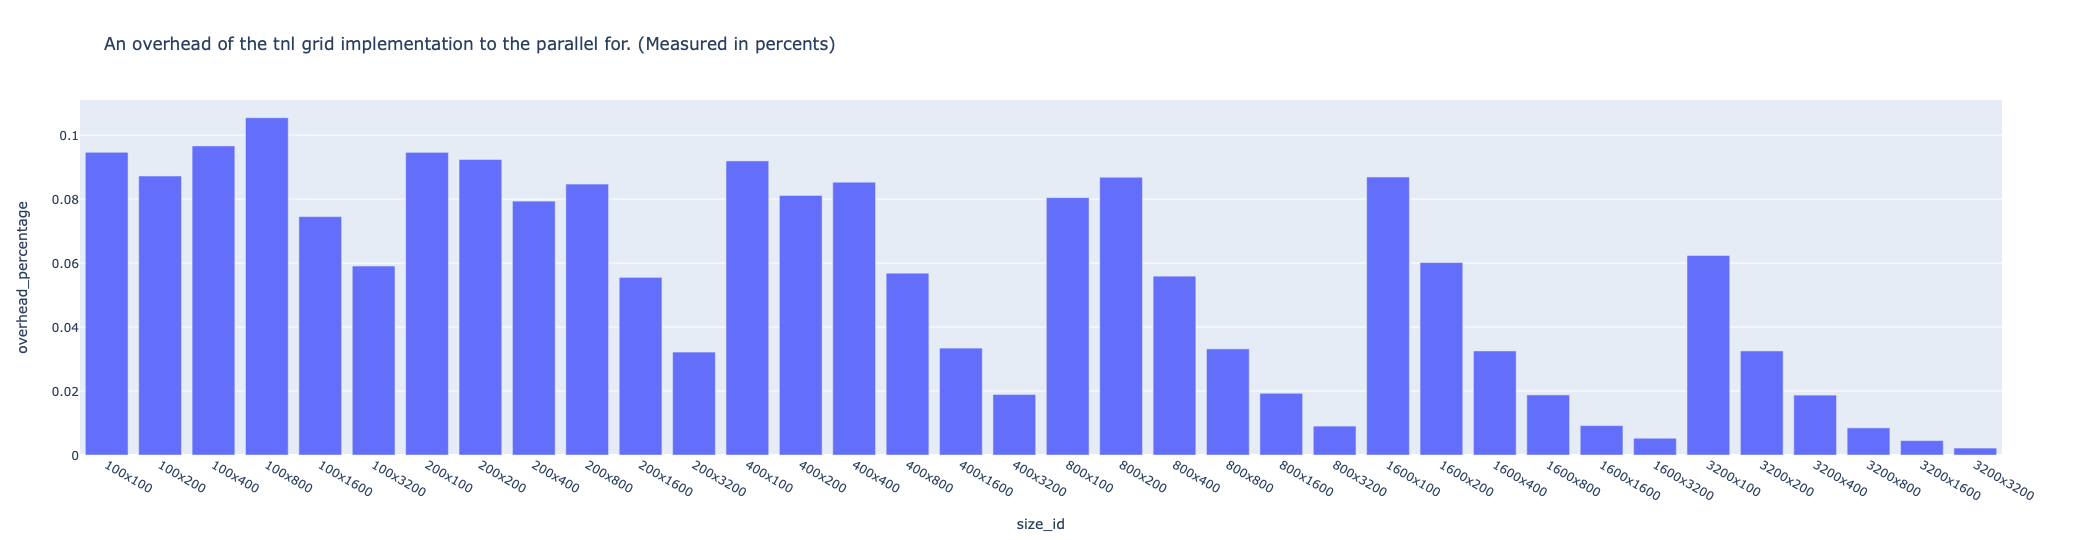

In [25]:
plot_heat_equation_benchmarks('data/HeatEquation_NVCC/', 'cuda', 'float', 'A comparative graph of heat equation with CUDA device and float precision. Compiled with NVCC.');

For host there is a singificant overhead added by the TNL grid. The reason is that the NVCC can't inline nested lambda expressions, which the TNL uses.

> There’s one caveat: __host__ __device__ lambdas may have worse performance in host code compared to plain unannotated host lambdas. Due to an implementation constraint, the CUDA compiler wraps the original extended __host__ __device__ lambda in an instance of std::function, in the host code sent to the host compiler. As a result, the host compiler may not be able to inline the body of the original __host__ __device__ lambda at the call site. If the __host__ __device__ lambda body is short and the lambda is being called frequently from host code, this may have a significant performance impact.  To reduce the potential performance loss, we can try increasing  the amount of code in the lambda body thereby  reducing  the overall impact of the indirect function call through std::function. Another option is to convert the lambda to a named ‘functor’ type that provides an operator(); a downside is that CUDA C++ requires the named functor type to be non-local if it participates in a __global__ template instantiation. [Source](https://developer.nvidia.com/blog/new-compiler-features-cuda-8/)

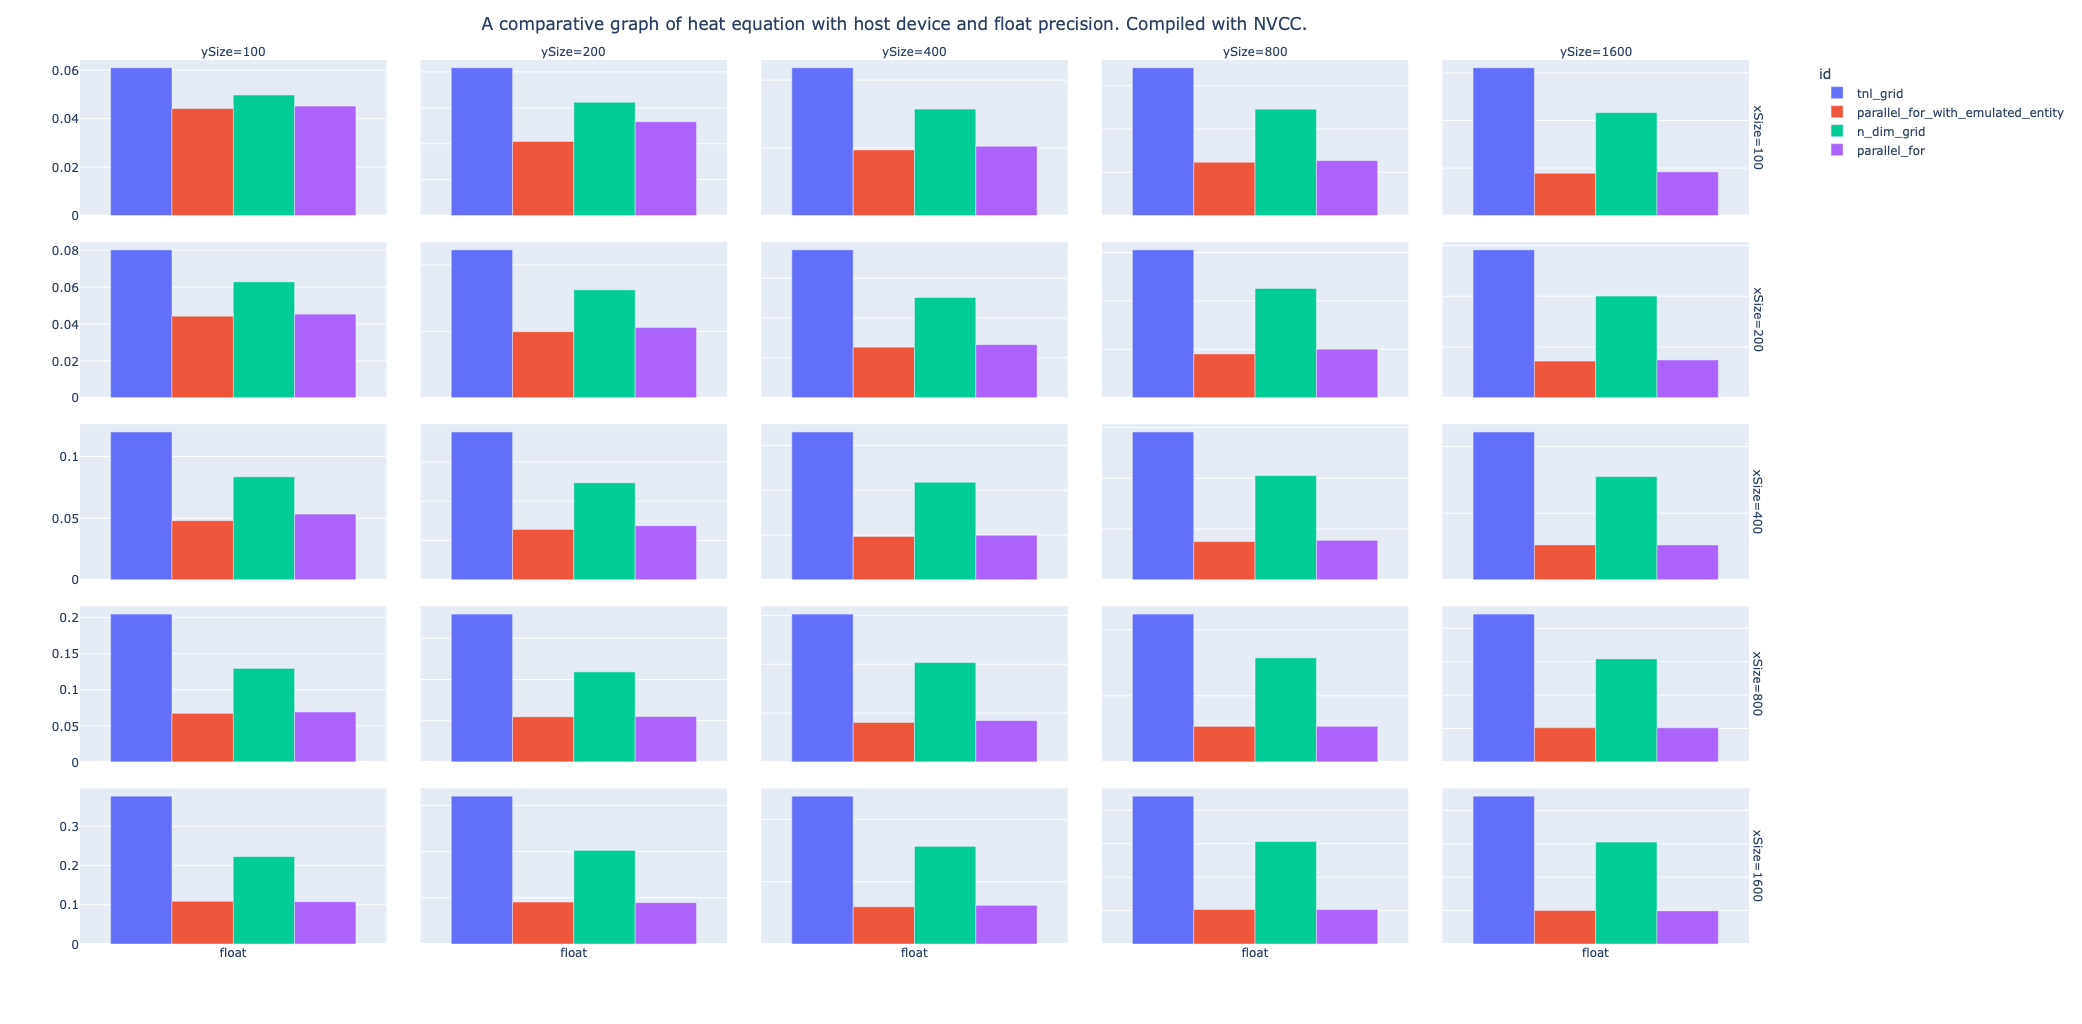

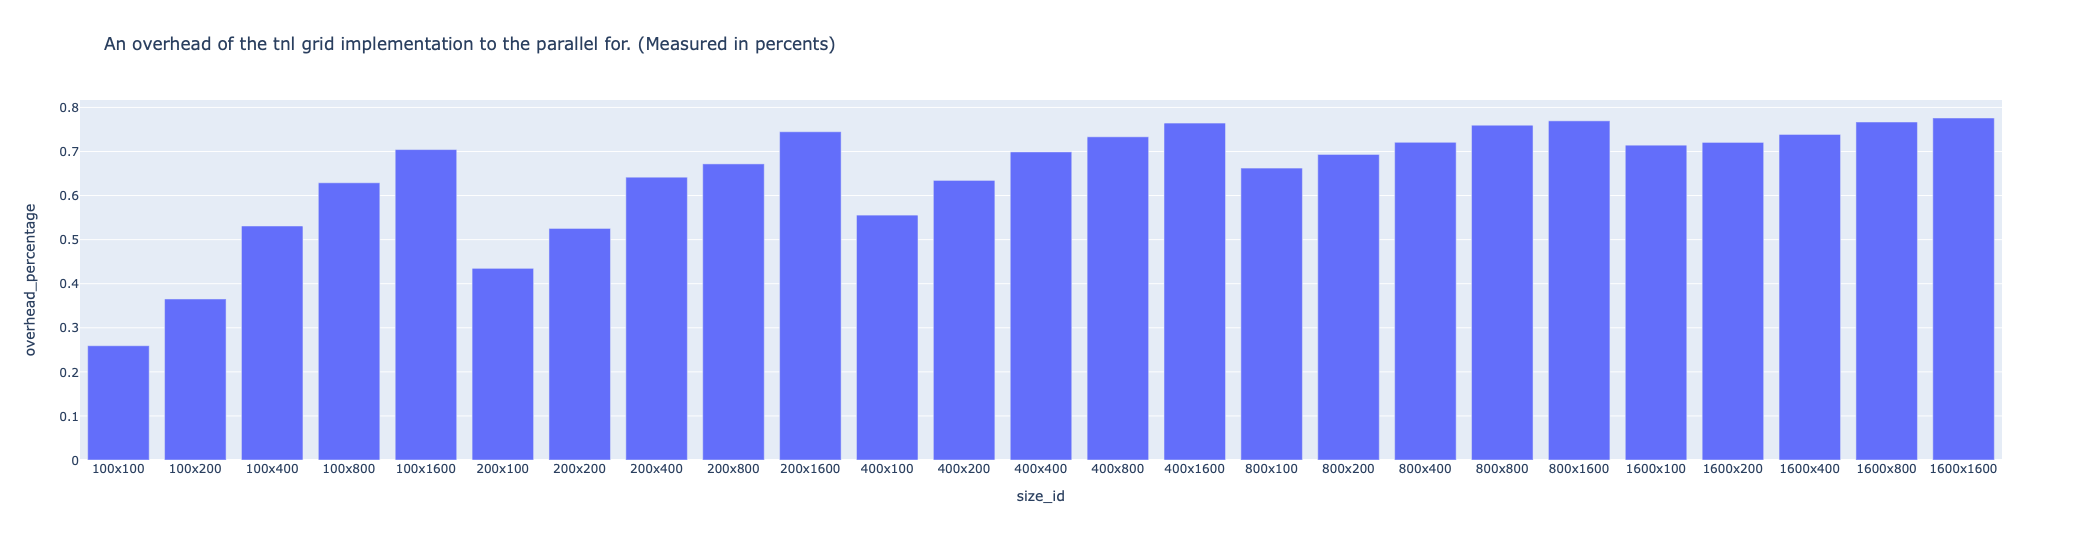

In [26]:
plot_heat_equation_benchmarks('data/HeatEquation_NVCC/', 'host', 'float', 'A comparative graph of heat equation with host device and float precision. Compiled with NVCC.');

## Double precision

For small kernel sizes, the higher overhead percentage is acceptable, because they don't fully occupy the GPU and they execute signficantly faster, than the large kernels. 

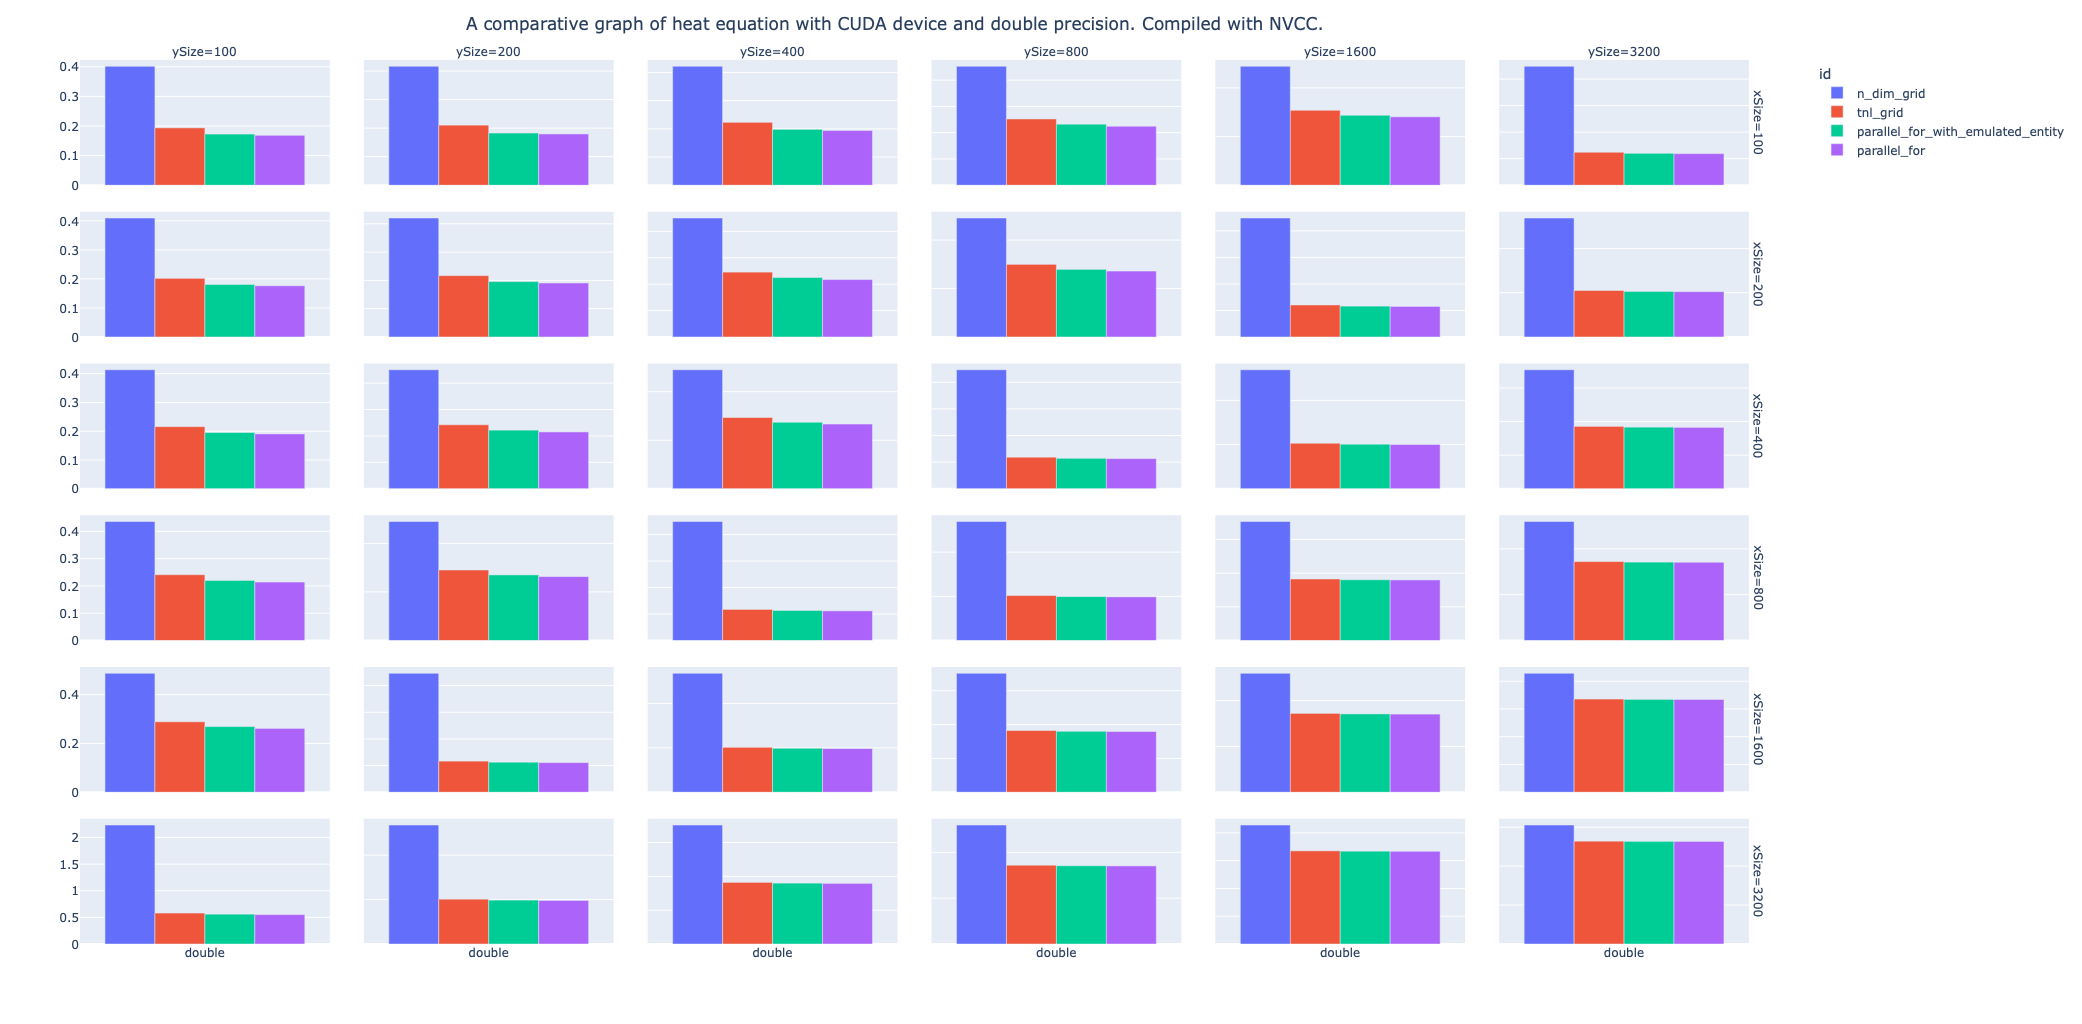

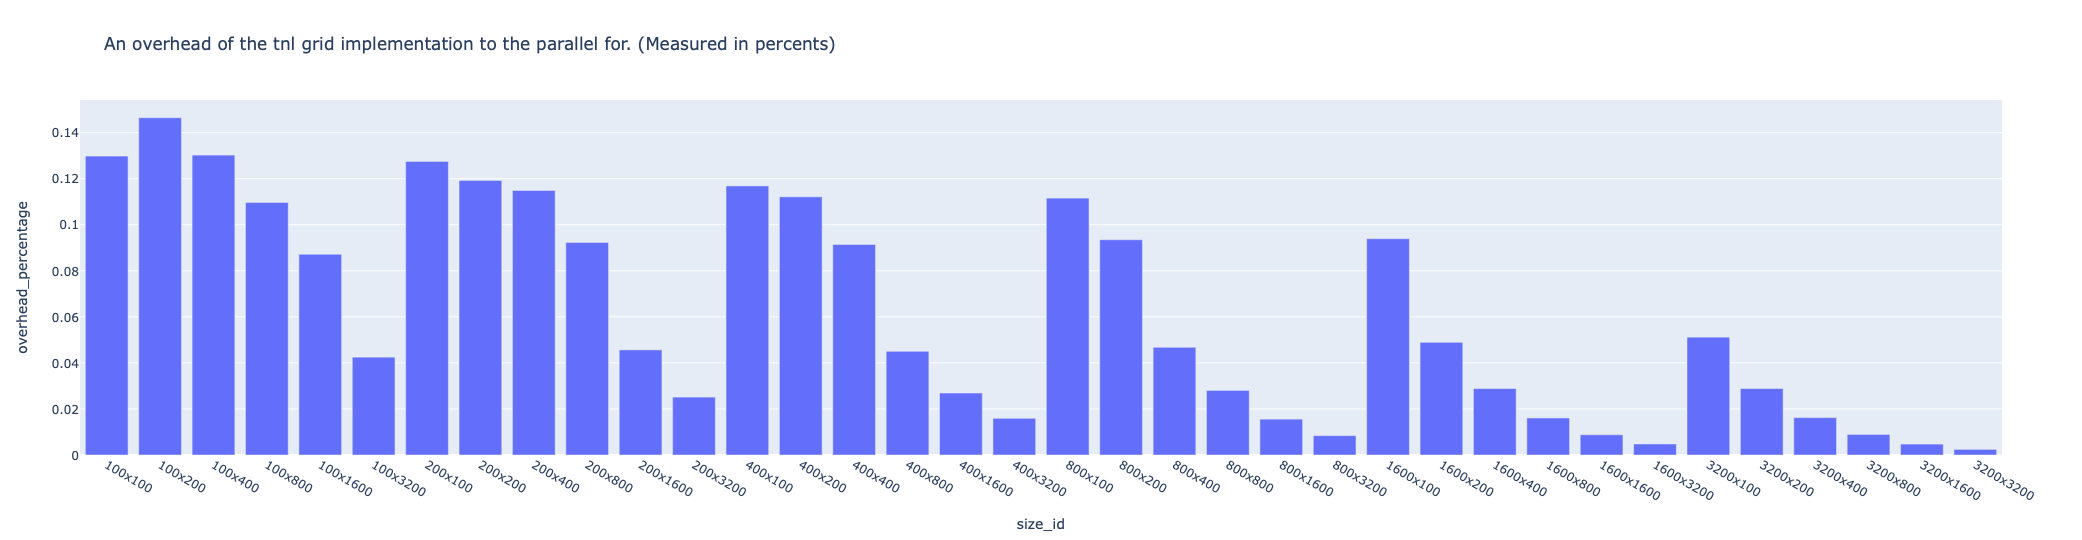

In [27]:
plot_heat_equation_benchmarks('data/HeatEquation_NVCC/', 'cuda', 'double', 'A comparative graph of heat equation with CUDA device and double precision. Compiled with NVCC.');

For host there is a singificant overhead added by the TNL grid. The reason is that the NVCC can't inline nested lambda expressions, which the TNL uses.

> There’s one caveat: __host__ __device__ lambdas may have worse performance in host code compared to plain unannotated host lambdas. Due to an implementation constraint, the CUDA compiler wraps the original extended __host__ __device__ lambda in an instance of std::function, in the host code sent to the host compiler. As a result, the host compiler may not be able to inline the body of the original __host__ __device__ lambda at the call site. If the __host__ __device__ lambda body is short and the lambda is being called frequently from host code, this may have a significant performance impact.  To reduce the potential performance loss, we can try increasing  the amount of code in the lambda body thereby  reducing  the overall impact of the indirect function call through std::function. Another option is to convert the lambda to a named ‘functor’ type that provides an operator(); a downside is that CUDA C++ requires the named functor type to be non-local if it participates in a __global__ template instantiation. [Source](https://developer.nvidia.com/blog/new-compiler-features-cuda-8/)

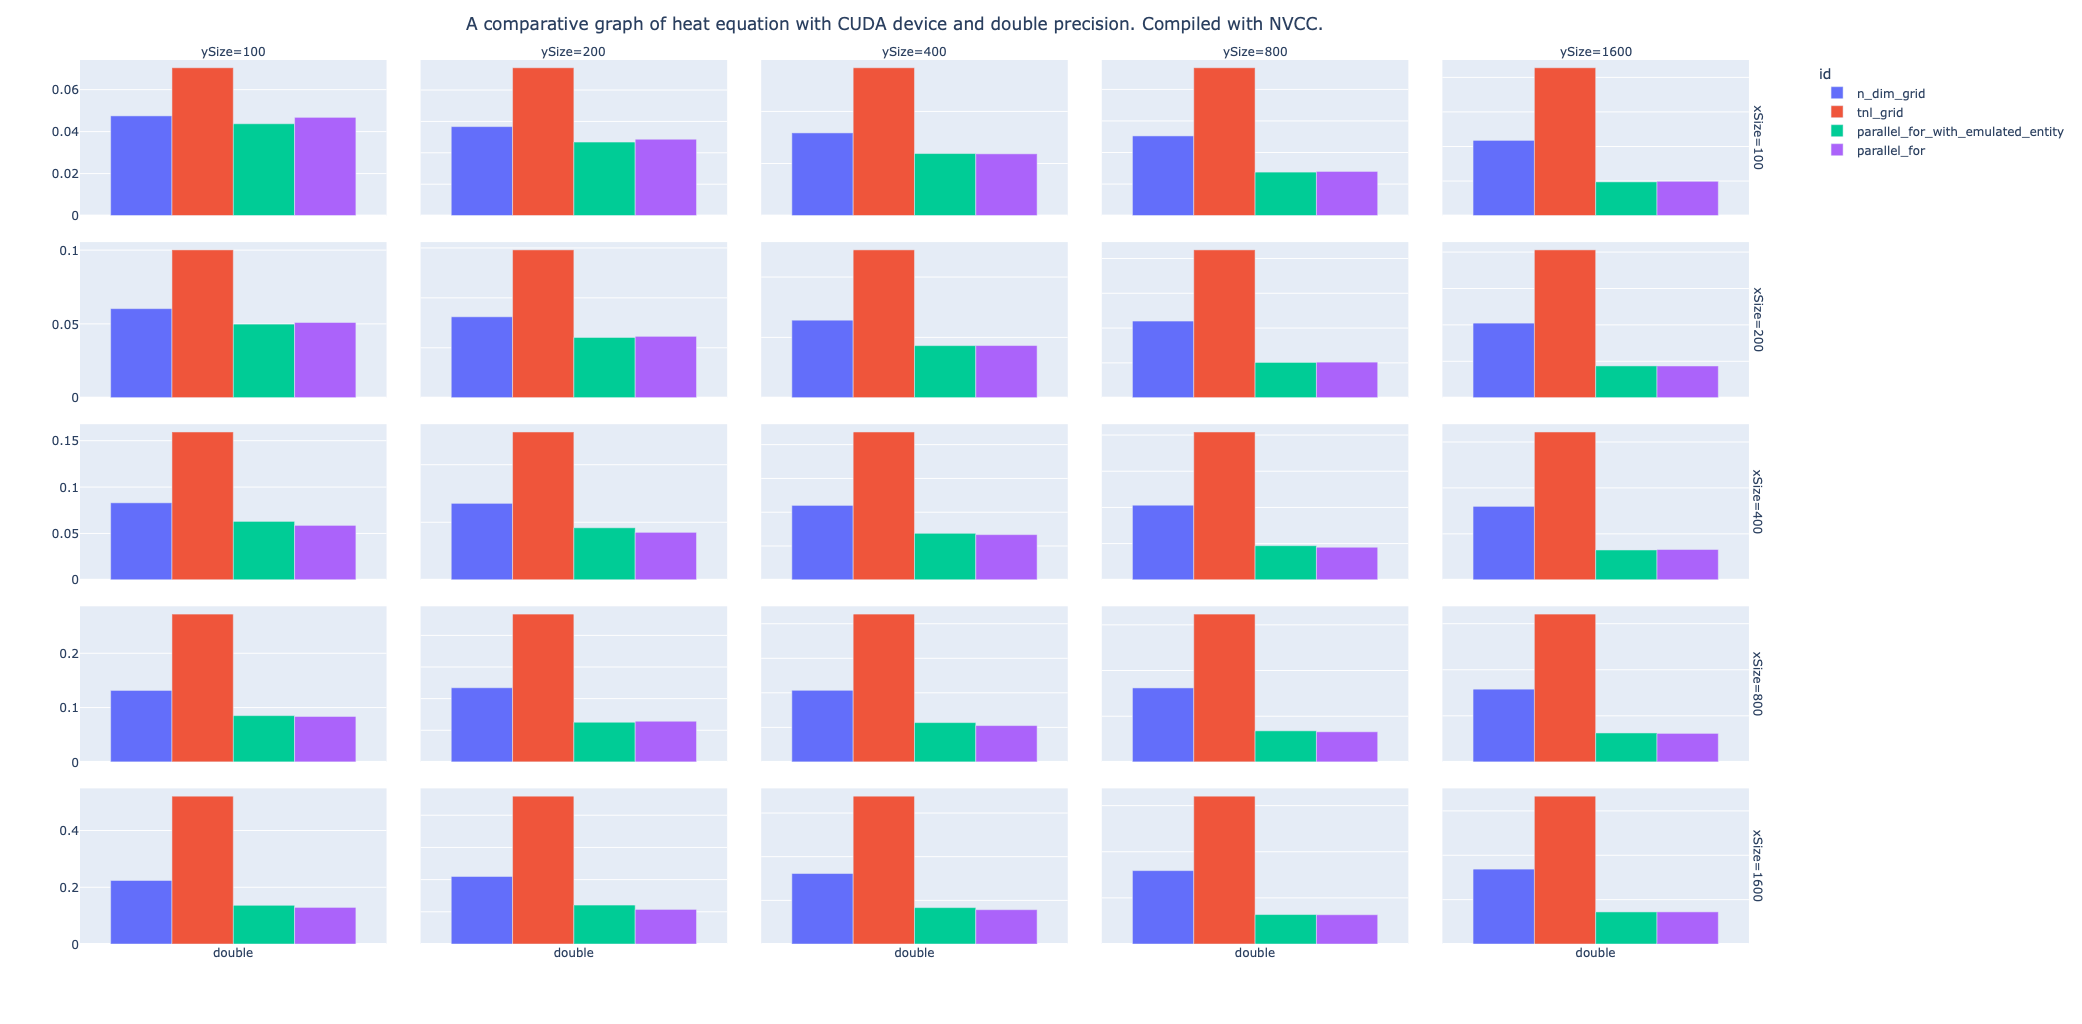

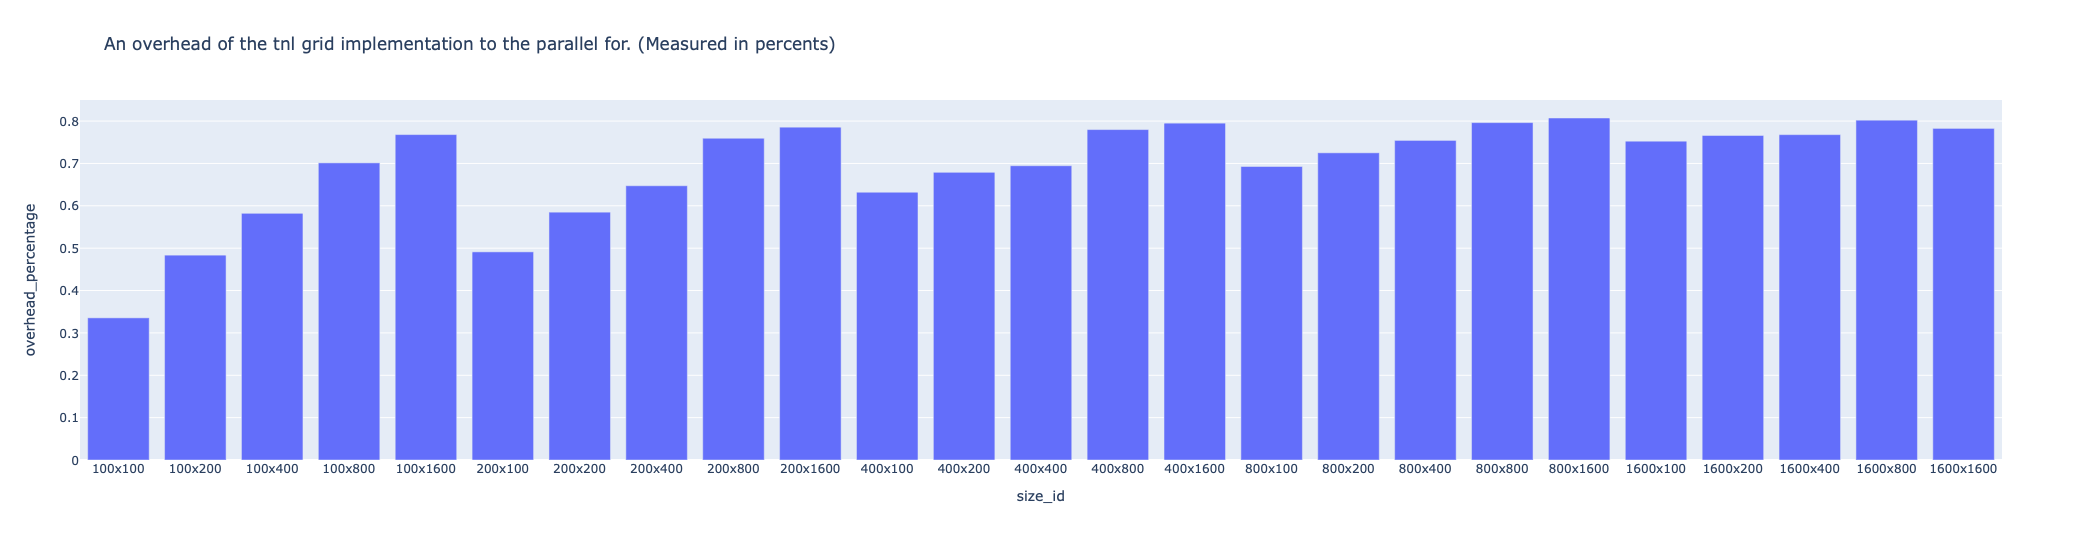

In [28]:
df= plot_heat_equation_benchmarks('data/HeatEquation_NVCC/', 'host', 'double', 'A comparative graph of heat equation with CUDA device and double precision. Compiled with NVCC.') 

# Heat Equation (GCC)

There is a problem with benchmarks compiled with NVCC and launched on the host
For that reason, additional measurements were done for benchmarks compiled with the GCC only.

## Float precision

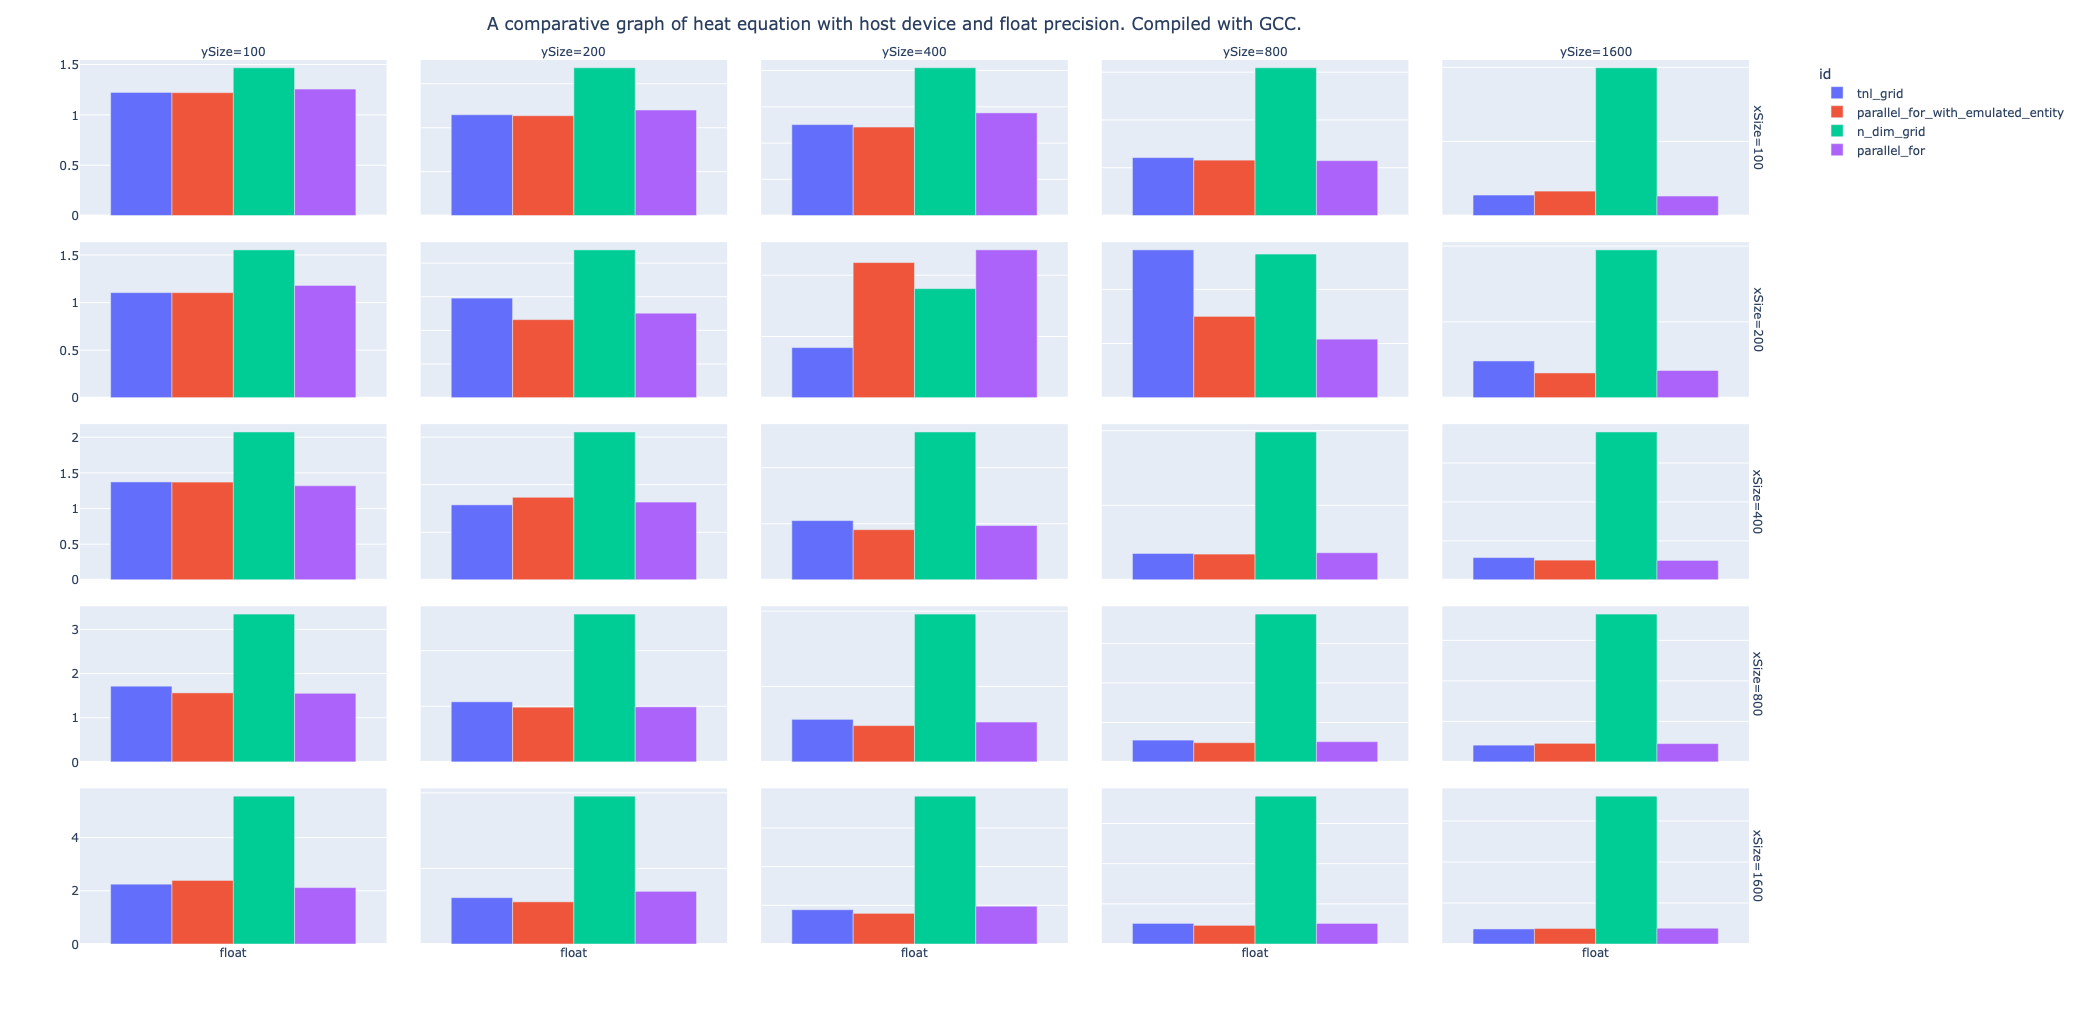

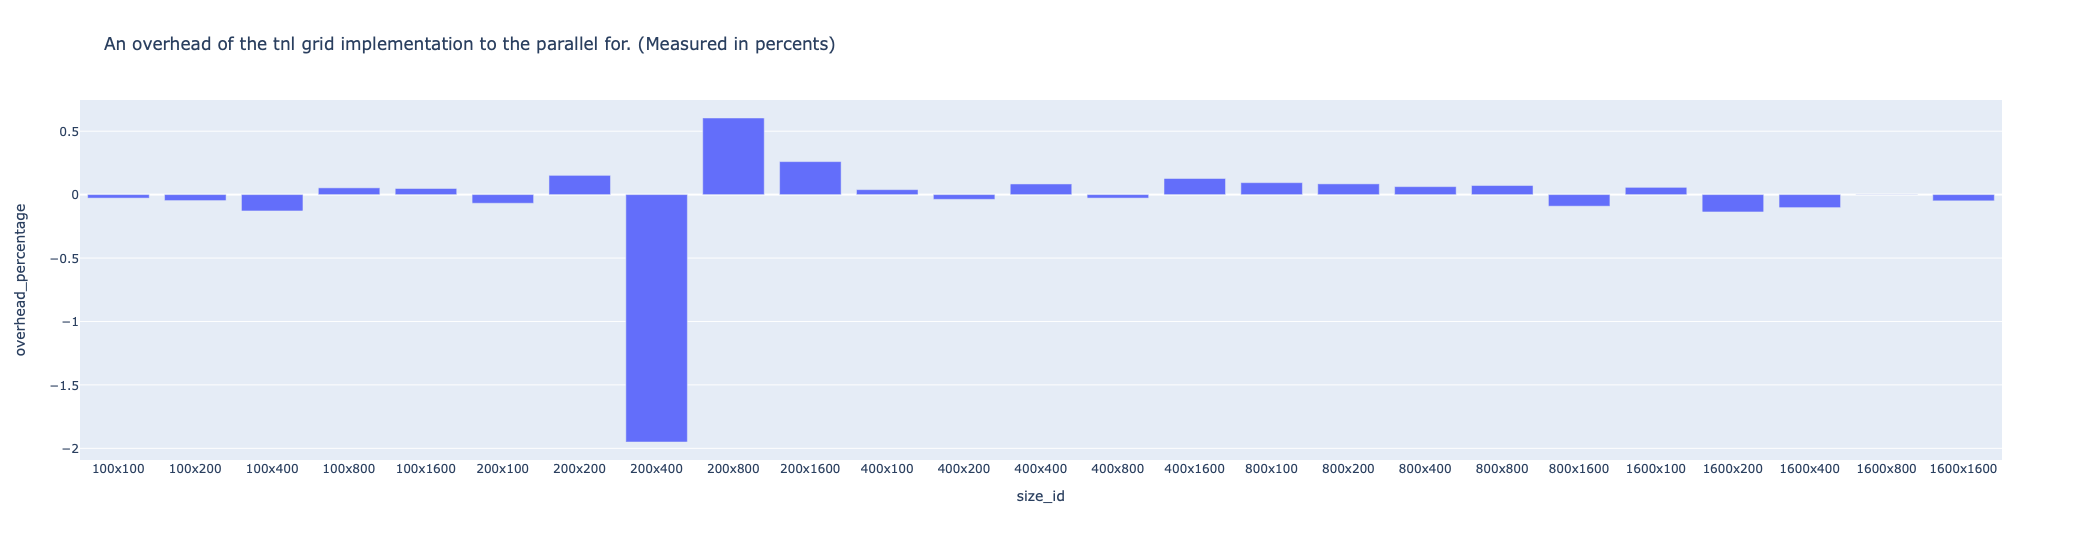

In [29]:
plot_heat_equation_benchmarks('data/HeatEquation_GCC/', 'host', 'float', 'A comparative graph of heat equation with host device and float precision. Compiled with GCC.');

## Double precision

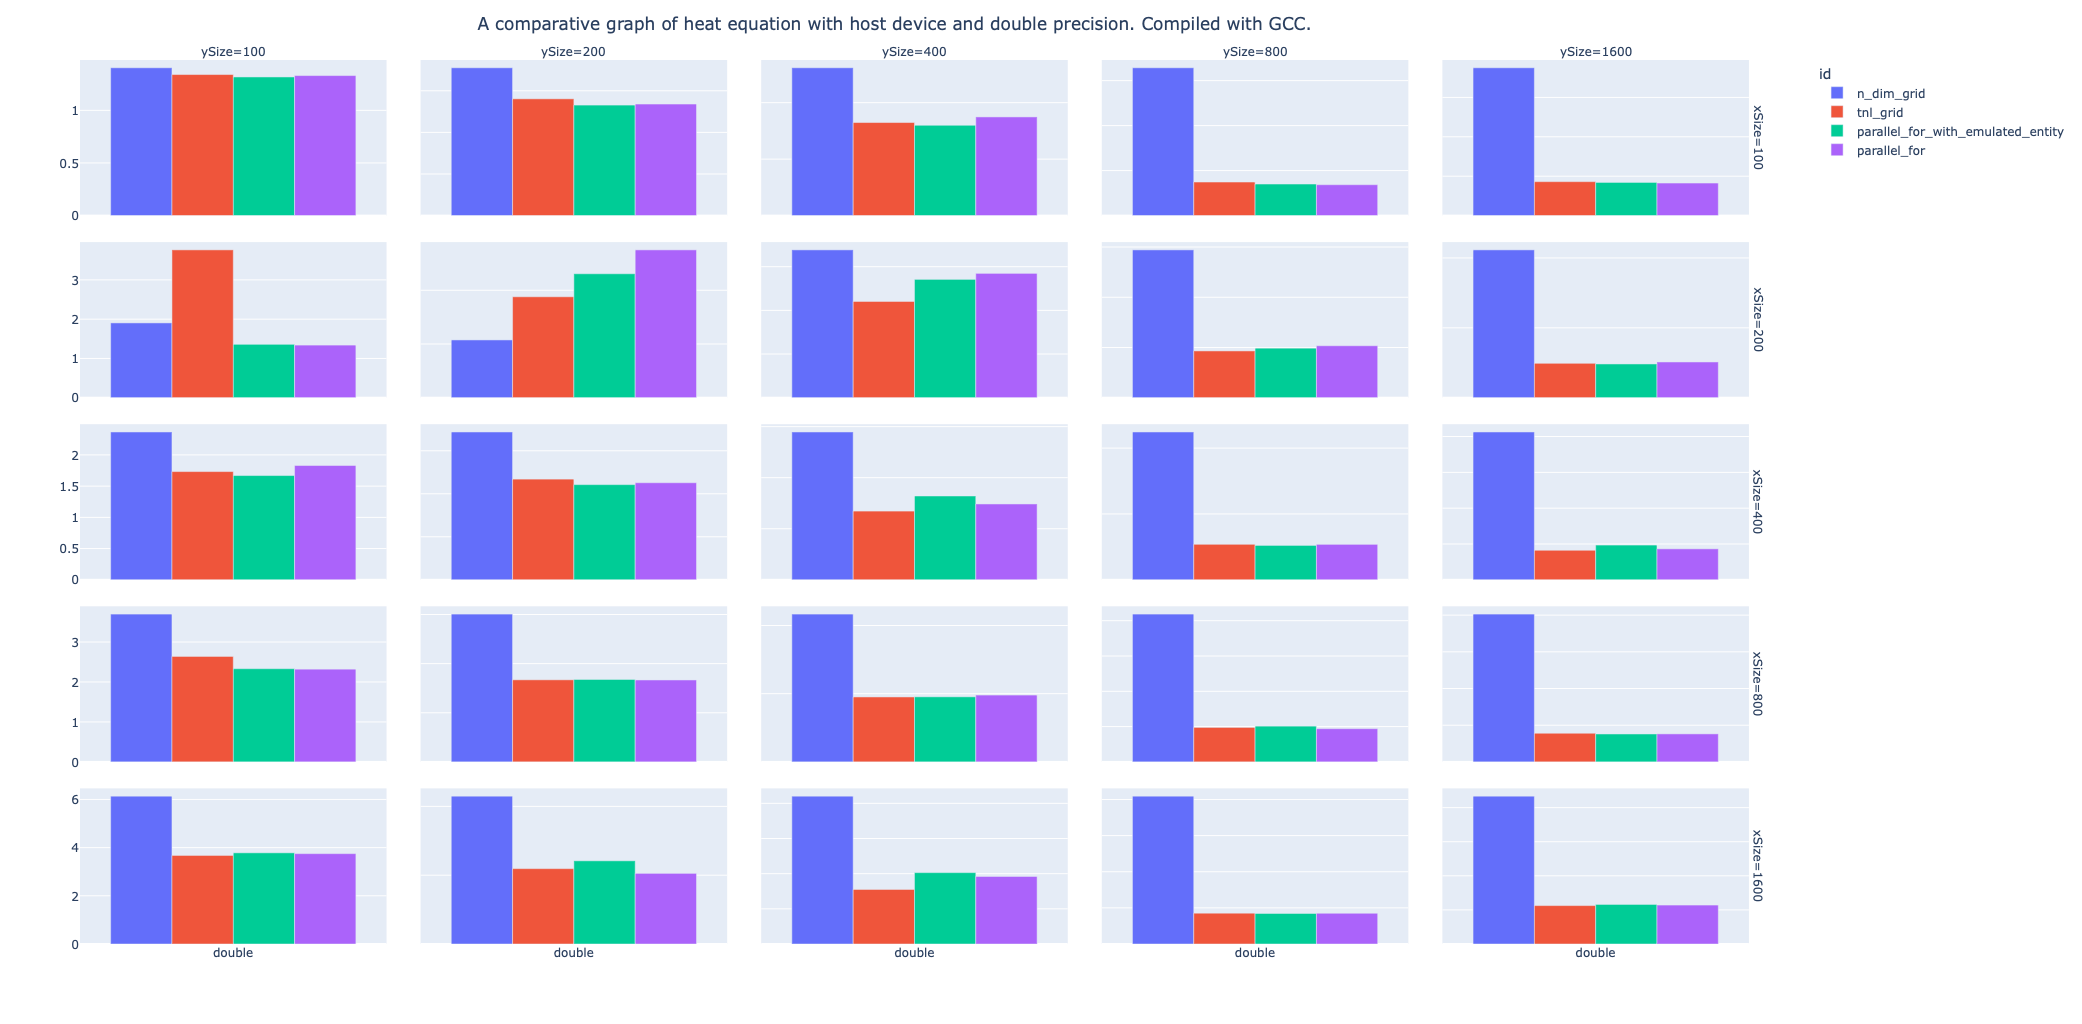

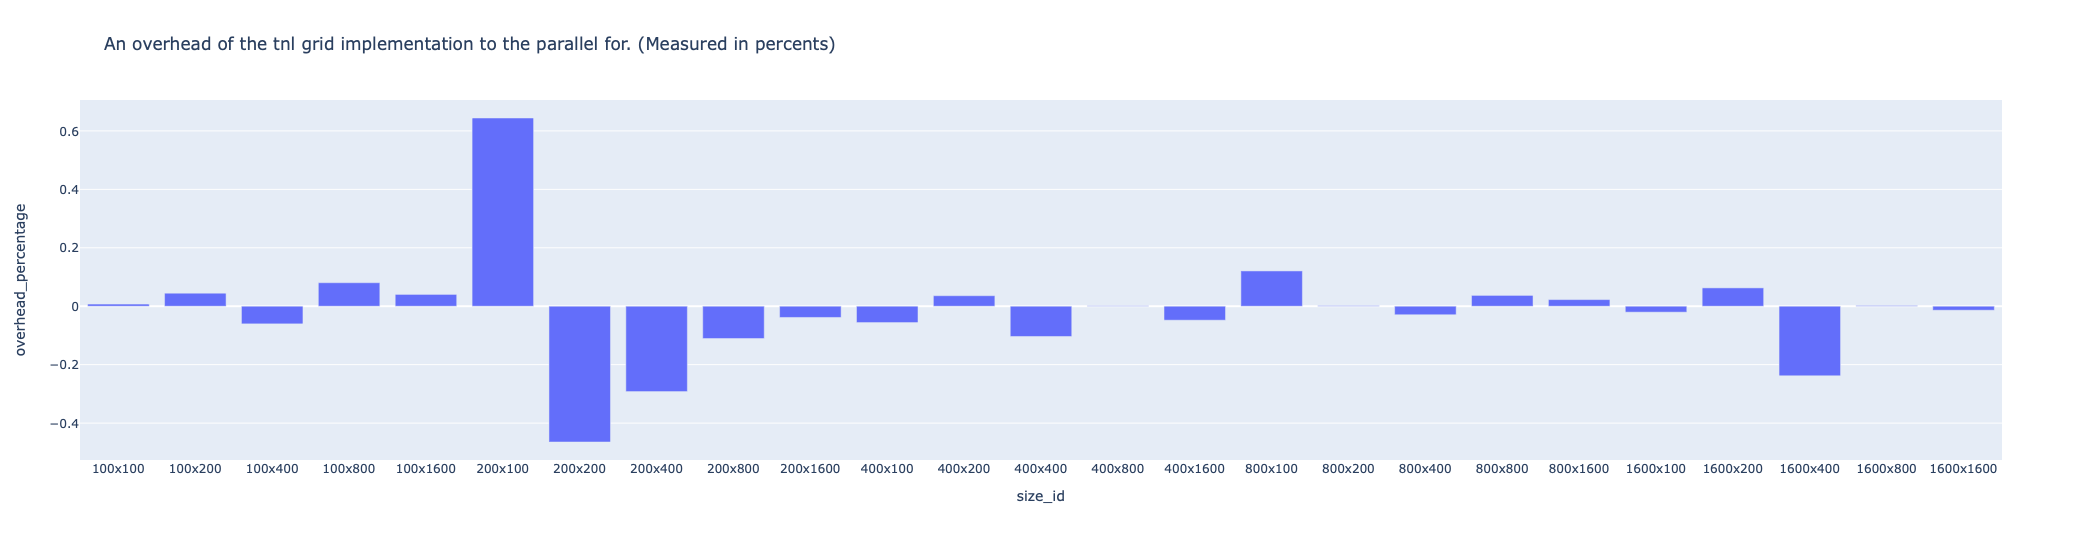

In [30]:
df = plot_heat_equation_benchmarks('data/HeatEquation_GCC/', 'host', 'double', 'A comparative graph of heat equation with host device and double precision. Compiled with GCC.') ;

In [31]:
df.groupby(['xSize', 'ySize', 'performer', 'id']).max().loc[1600, 1600]

precision      time    stddev  \
performer id                                                                
host      n_dim_grid                           double  86.70929  0.493388   
          parallel_for                         double  22.83887  0.687068   
          parallel_for_with_emulated_entity    double  23.20492  1.499150   
          tnl_grid                             double  22.53215  0.645787   

                                             stddev/time loops     bandwidth  \
performer id                                                                   
host      n_dim_grid                            0.005690    10  2.952394e+04   
          parallel_for                          0.030083    10  1.120896e+05   
          parallel_for_with_emulated_entity     0.064605    10  1.103214e+05   
          tnl_grid                              0.028661    10  1.136154e+05   

                                            speedup    size_id problem_size  
performer id                                                                 
host      n_dim_grid                            N/A  1600x1600      2560000  
          parallel_for                          N/A  1600x1600      2560000  
          parallel_for_with_emulated_entity     N/A  1600x1600      2560000  
          tnl_grid                              N/A  1600x1600      2560000

# Convolution (1-D)

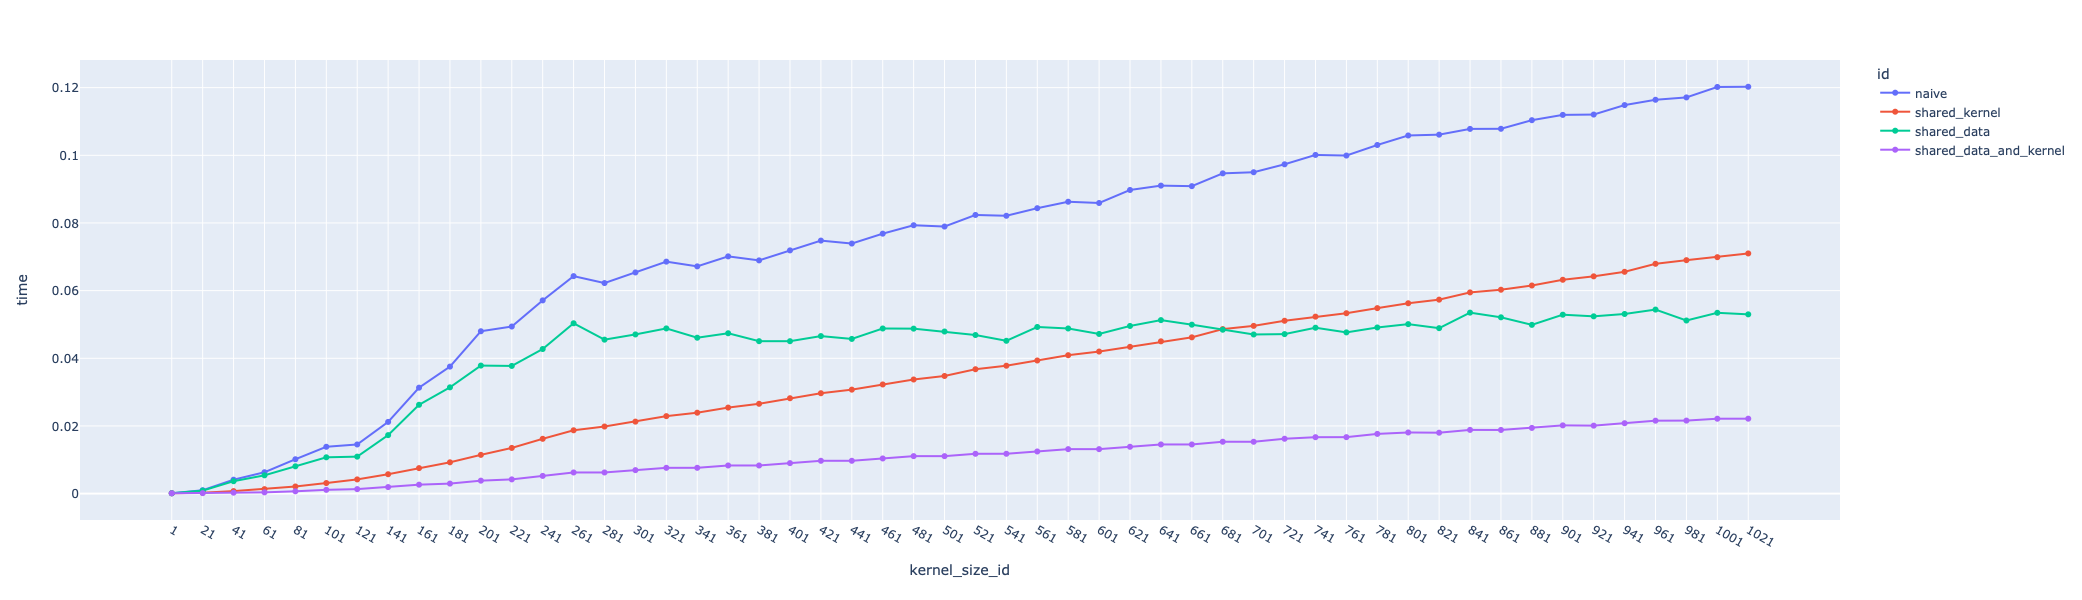

In [32]:
plot_convolution_benchmarks('data/Convolution_QuadroP6000', '1D', 4096 * 4096);

# Convolution (2-D)

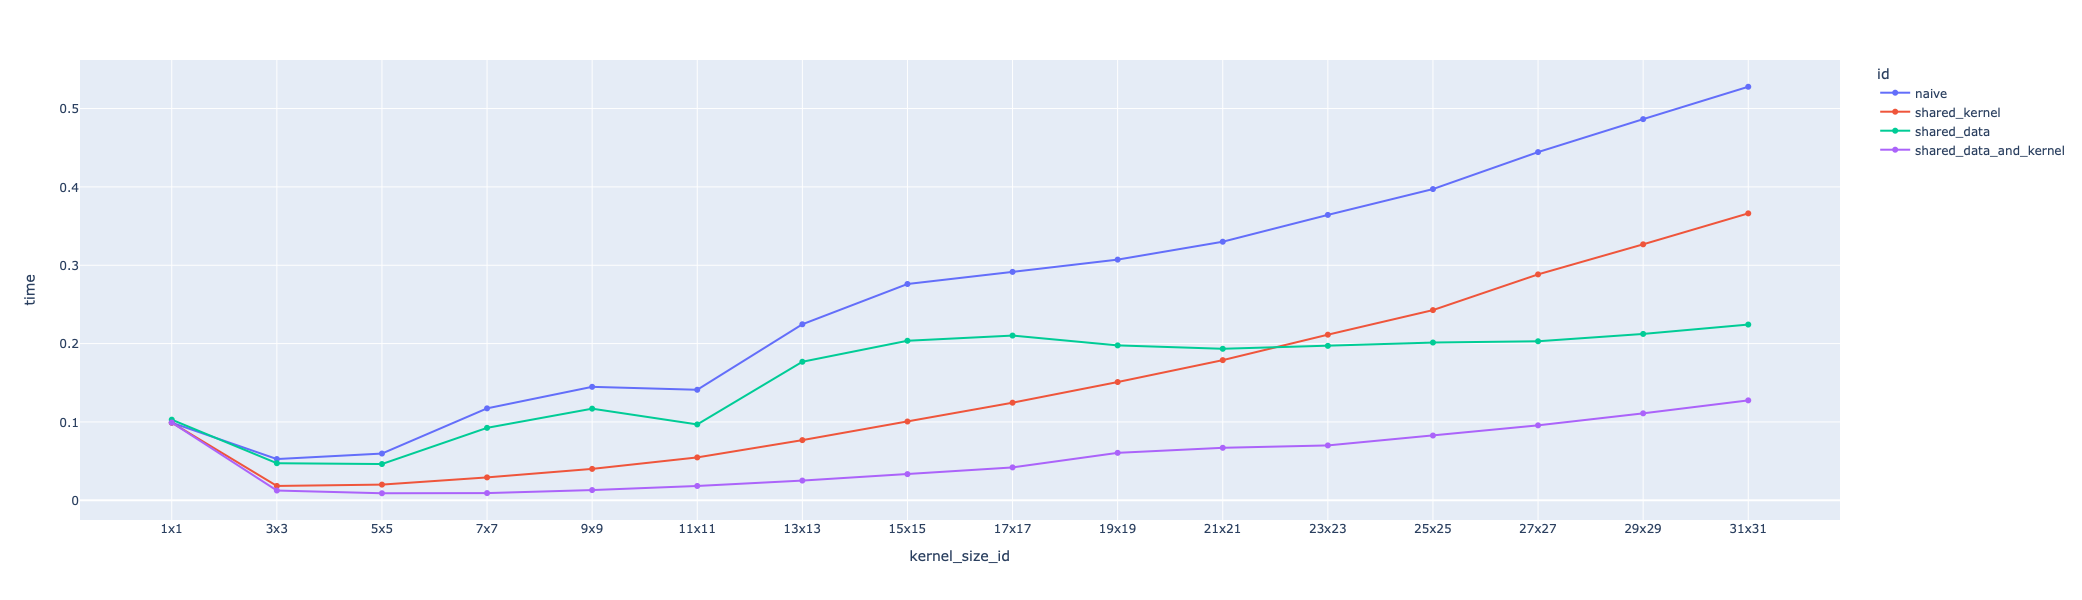

In [33]:
plot_convolution_benchmarks('data/Convolution_QuadroP6000', '2D', 8196);

# Convolution (3-D)

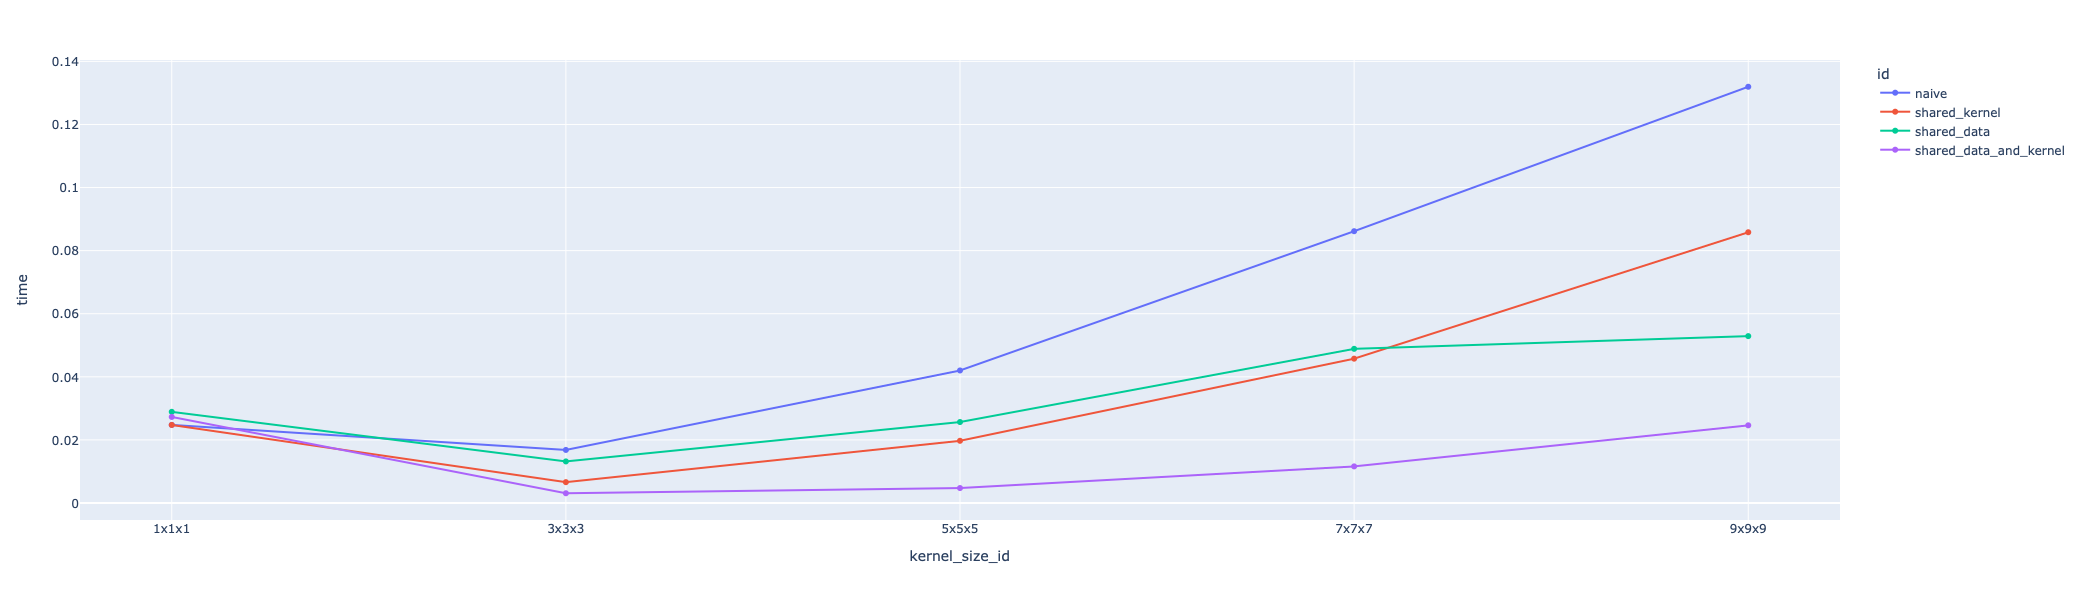

In [34]:
plot_convolution_benchmarks('data/Convolution_QuadroP6000', '3D', 256);

# Heat equation and convolution

The duration is the 0.36 sec.

The iteration length is 0.000005.

The time step is 0.005

## Heat equation

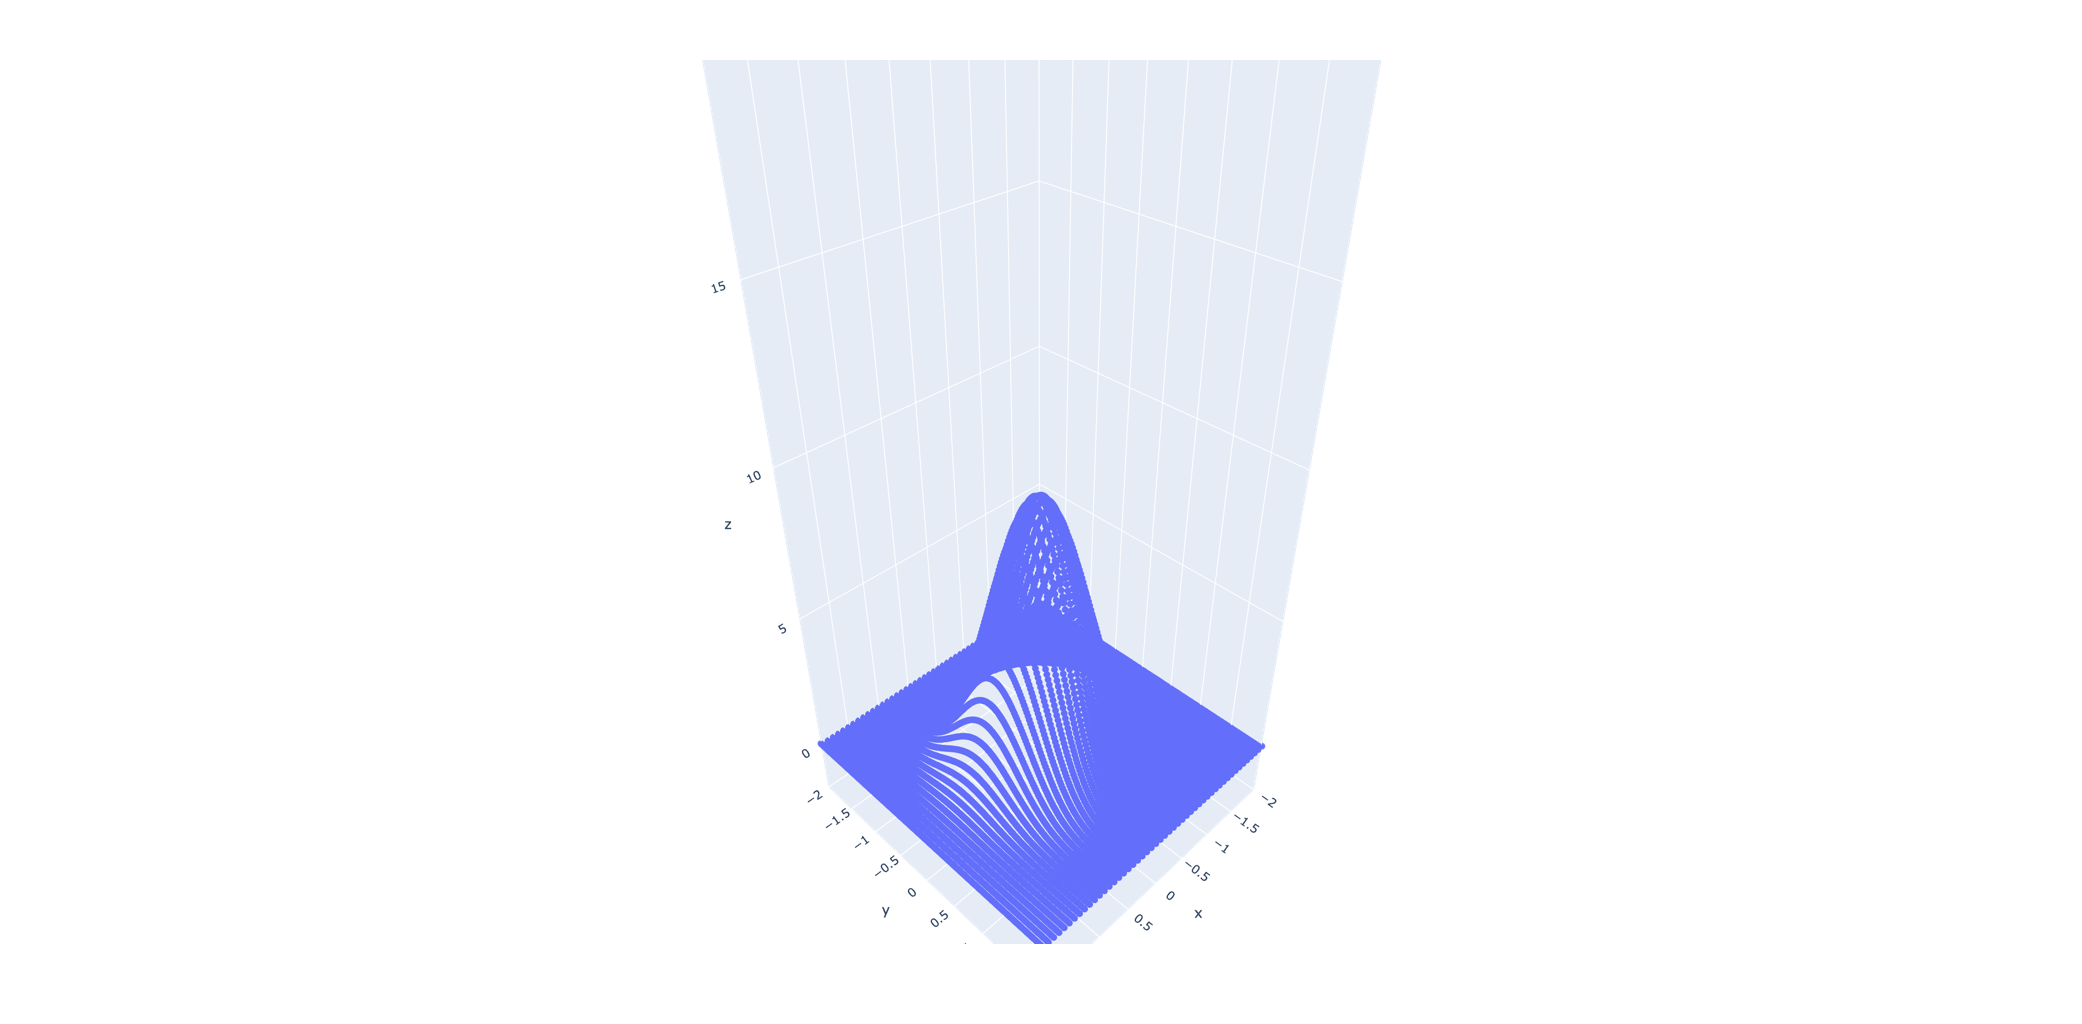

In [35]:
# Enter the key as the 1000 of the iterations, so initial data has key 0000, the next key is 1000 and so on
dfs = plot_heat_equation_domain('data/HeatEquation_Data', '16000');

In [36]:
# Uncomment to see simple animation
#plot_heat_equation_domain_animated('data/HeatEquation_Data')

## Convolution

On the following graphs the pseudo-analytical solution of the heat equation with convolution is presented. \
The visualization is similar to the heat equation version. 

However, it is important to correctly select the size of the domain on which Gaussian function is approximated.
If chosen incorrectly, the approximation will cut the boundaries of the kernel or otherwise not enough observations in the important part of the kernel will be taken.

To obtain data for the 4th iteration, the following command was used.
```
./YOUR_BINARY --startTime 0.015 --finalTime 0.020 --domain-x-size 4 --domain-y-size 4 --kernel-domain-x-size 0.1 --kernel-domain-y-size 0.1 --kernel-x-size 25 --kernel-y-size 25
```

To obtain data for the 8th iteration, the following command was used.

```
./YOUR_BINARY --startTime 0.035 --finalTime 0.040 --domain-x-size 4 --domain-y-size 4 --kernel-domain-x-size 0.1 --kernel-domain-y-size 0.1 --kernel-x-size 31 --kernel-y-size 31
```

To obtain data for the 16th iteration, the following command was used.

```
./builddir/Debug/bin/HeatEquation_2_sharedDataAndKernel_main_heat_equation_solver-dbg --startTime 0.075 --finalTime 0.080 --domain-x-size 4 --domain-y-size 4 --kernel-domain-x-size 0.2 --kernel-domain-y-size 0.2 --kernel-x-size 31 --kernel-y-size 31
```

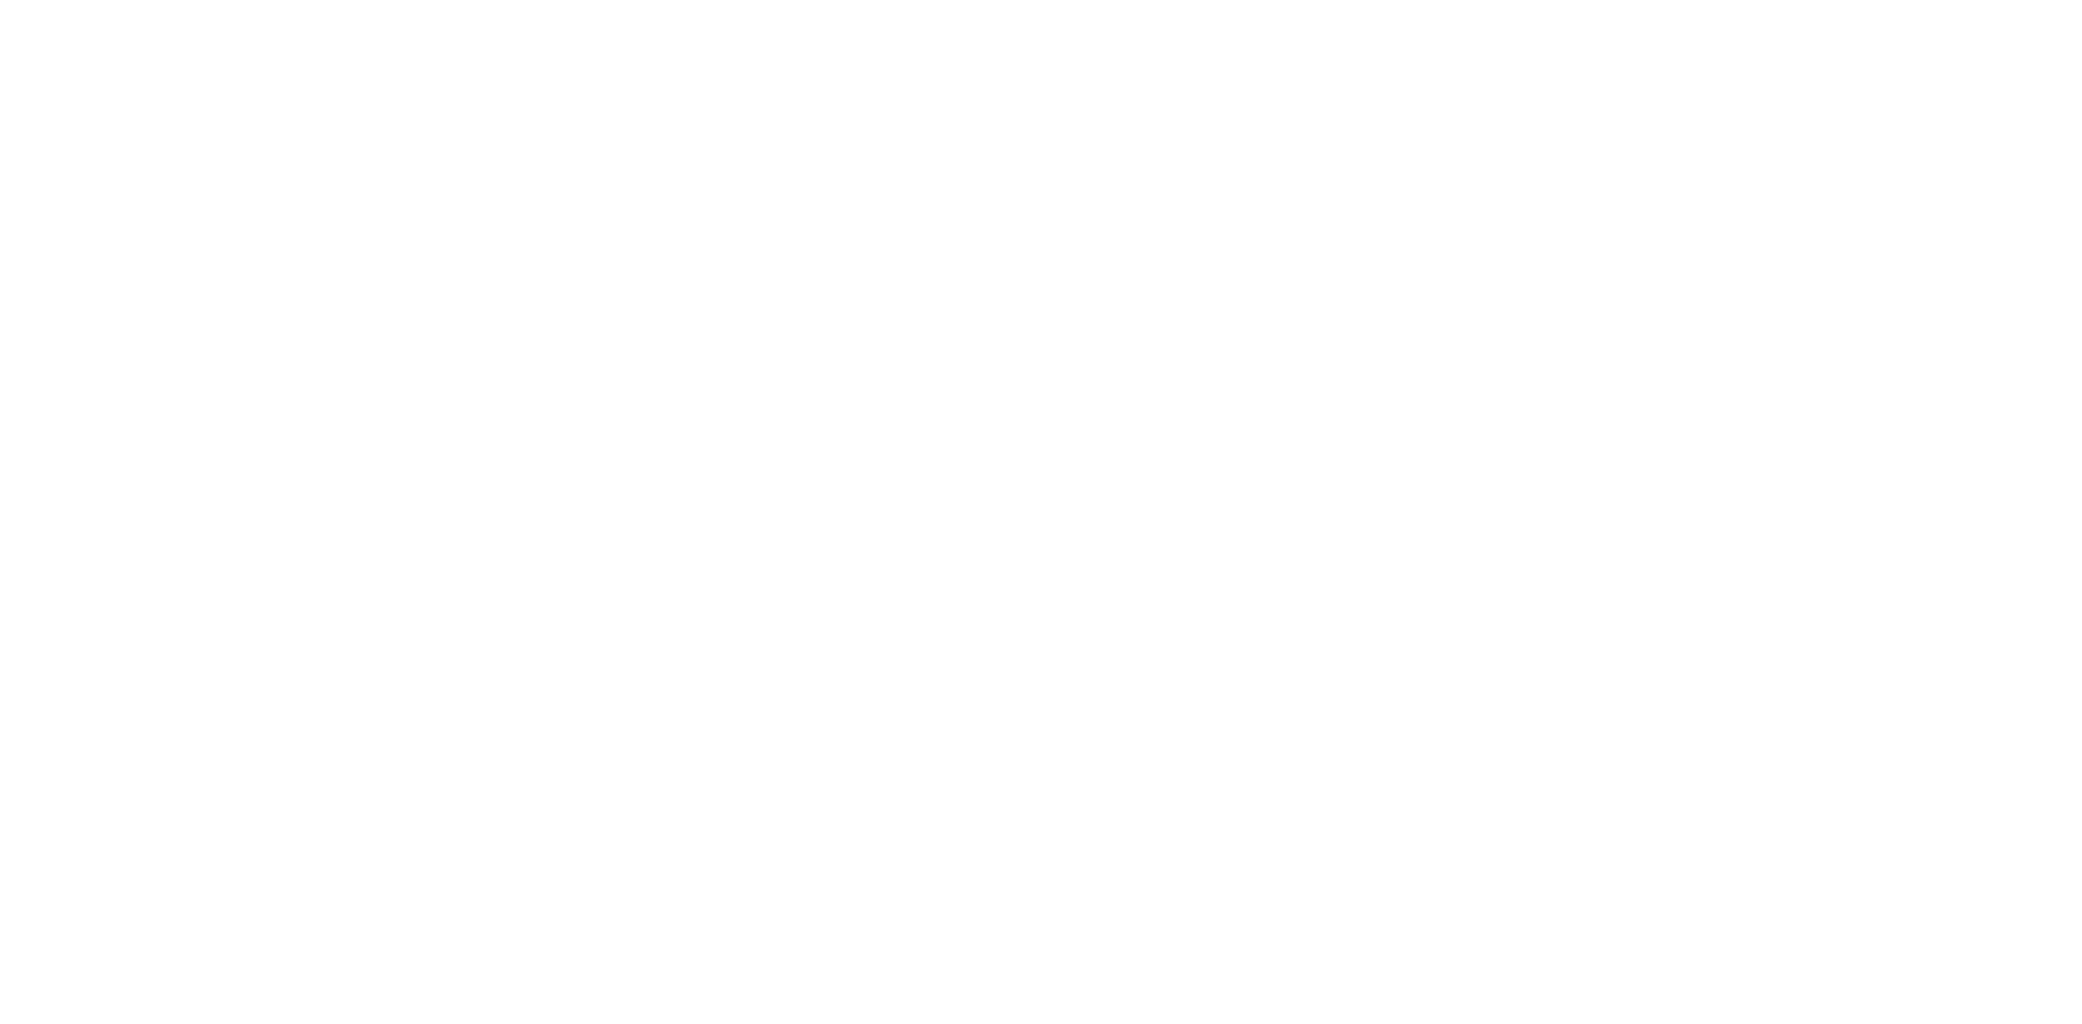

In [37]:
dfs = plot_heat_equation_domain('data/HeatEquation_Convolution', '16')

In [38]:
# Uncomment to see simple animation
#plot_heat_equation_domain_animated('data/HeatEquation_Convolution/')